In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, Permute, Lambda


In [12]:
# ฟังก์ชันสำหรับการดึงคุณลักษณะจากไฟล์เสียง (MFCC)
def extract_features(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs, sr  # คืนค่า MFCC และ sample rate
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((14, max_pad_len))

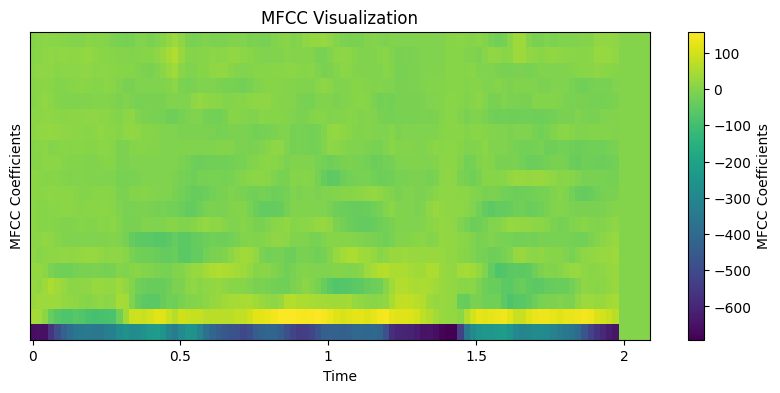

In [17]:
# 📌 ทดสอบกับไฟล์เสียงตัวอย่าง
file_path = "/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/test/surprised/OAF_gun_ps.wav"  # 🔹 ใส่ path ของไฟล์เสียง
mfcc_features, sr = extract_features(file_path)

# 🔹 แสดงภาพ MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_features, sr=sr, x_axis="time", cmap="viridis")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Visualization")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()

In [3]:
def load_data(audio_folder):
    filenames = []
    labels = []
    for emotion in os.listdir(audio_folder):
        emotion_folder = os.path.join(audio_folder, emotion)
        if os.path.isdir(emotion_folder):
            for filename in os.listdir(emotion_folder):
                if filename.endswith(".wav"):
                    file_path = os.path.join(emotion_folder, filename)
                    filenames.append(file_path)
                    labels.append(emotion)
    return filenames, labels



In [4]:
# ฟังก์ชันสร้าง Positional Encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

def multi_head_attention(query, key, value, num_heads):
    d_model = query.shape[-1]  # ตรวจสอบค่า d_model

    if d_model is None:
        raise ValueError("d_model ต้องถูกกำหนดค่า (ไม่ใช่ None)")

    if d_model % num_heads != 0:
        raise ValueError(f"d_model ({d_model}) ต้องหาร num_heads ({num_heads}) ลงตัว")

    depth = d_model // num_heads

    query = Dense(d_model)(query)
    key = Dense(d_model)(key)
    value = Dense(d_model)(value)

    # ใช้ Lambda Layer เพื่อดึง batch_size
    batch_size_fn = Lambda(lambda x: tf.shape(x)[0])
    batch_size = batch_size_fn(query)

    # ใช้ Lambda Layer เพื่อ reshape ข้อมูล
    reshape_fn = Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1, num_heads, depth)))
    query = reshape_fn(query)
    key = reshape_fn(key)
    value = reshape_fn(value)

    # Transpose
    query = Permute((2, 1, 3))(query)
    key = Permute((2, 1, 3))(key)
    value = Permute((2, 1, 3))(value)

    # Attention
    attention_scores = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True))([query, key])
    attention_scores = Lambda(lambda x: x / tf.math.sqrt(tf.cast(depth, tf.float32)))(attention_scores)
    attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=-1))(attention_scores)
    attention_output = Lambda(lambda x: tf.matmul(x[0], x[1]))([attention_weights, value])

    # Reshape กลับ
    attention_output = Permute((2, 1, 3))(attention_output)
    attention_output = Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1, d_model)))(attention_output)

    return attention_output




In [5]:
def transformer_block(inputs, num_heads, dff, d_model, dropout_rate=0.1):
    print(f'Input shape before attention: {inputs.shape}')  # ตรวจสอบขนาดของ inputs ก่อนการทำงาน
    # ตรวจสอบให้แน่ใจว่าอินพุตมีรูปทรงถูกต้อง: (batch_size, seq_length, d_model)
    if len(inputs.shape) == 2:  # ถ้ามีแค่ (seq_length, d_model) เพิ่ม batch dimension
        inputs = tf.expand_dims(inputs, axis=0)  # เปลี่ยนรูปทรงเป็น (1, seq_length, d_model)
    
    print(f'Input shape after expanding dimensions: {inputs.shape}')  # ตรวจสอบขนาดหลังการขยายมิติ
    # ใช้ multi-head attention ที่รับ inputs อยู่ในรูป (batch_size, seq_length, d_model)
    attention_output = multi_head_attention(inputs, inputs, inputs, num_heads)
    print(f'Attention output shape: {attention_output.shape}')  # ตรวจสอบขนาดหลังการทำ attention

    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = Dense(dff, activation='relu')(attention_output)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return ffn_output



In [6]:
def extract_features_from_all(filenames, max_pad_len=100):
    features = []
    for file in filenames:
        mfccs = extract_features(file, max_pad_len)
        features.append(mfccs)
    return np.array(features)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

def create_transformer_model(input_shape, num_classes, num_heads=2, dff=128, d_model=64, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    pos_enc = positional_encoding(input_shape[0], d_model)  # ใช้ shape ที่ถูกต้อง
    x = Dense(d_model)(inputs)
    
    # เพิ่ม positional encoding
    x = x + pos_enc
    print(f'Input shape after adding positional encoding: {x.shape}')  # ตรวจสอบขนาดหลังการเพิ่ม positional encoding
    
    for _ in range(num_layers):
        x = transformer_block(x, num_heads, dff, d_model, dropout_rate)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [8]:
train_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/train'
val_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/val'
test_folder = '/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/test'
train_filenames, train_labels = load_data(train_folder)
test_filenames, test_labels = load_data(test_folder)
val_filenames, val_labels = load_data(val_folder)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)
y_val_encoded = label_encoder.transform(val_labels)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)
y_val_encoded = to_categorical(y_val_encoded)
X_train_features = extract_features_from_all(train_filenames)
X_test_features = extract_features_from_all(test_filenames)
X_val_features = extract_features_from_all(val_filenames)
# เพิ่มมิติข้อมูลสำหรับ RNN
X_test = X_test_features
X_train = X_train_features  # ไม่เพิ่มมิติ
X_val = X_val_features  # ไม่เพิ่มมิติ

print(X_train.shape)



(1960, 20, 100)


In [ ]:
n_classes = len(label_encoder.classes_)
if X_train.shape[1] is None or X_train.shape[2] is None:
    raise ValueError("input_shape ต้องไม่มีค่า None")

input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Input Shape: {input_shape}")  # Debugging

model = create_transformer_model(input_shape, n_classes)
model.summary()


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=60, validation_data=(X_val, y_val_encoded), callbacks=[early_stop])


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2168 - loss: 1.9195 - val_accuracy: 0.5679 - val_loss: 1.2285
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5429 - loss: 1.2530 - val_accuracy: 0.6464 - val_loss: 0.9791
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6275 - loss: 1.0098 - val_accuracy: 0.7750 - val_loss: 0.7103
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7460 - loss: 0.7089 - val_accuracy: 0.7929 - val_loss: 0.6219
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7771 - loss: 0.6303 - val_accuracy: 0.8000 - val_loss: 0.6054
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7803 - loss: 0.6038 - val_accuracy: 0.7429 - val_loss: 0.7674
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7615 - loss: 0.6788 - val_accuracy: 0.8071 - val_loss: 0.5769
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8193 - loss: 0.5032 - val_accuracy: 0.8500 - v

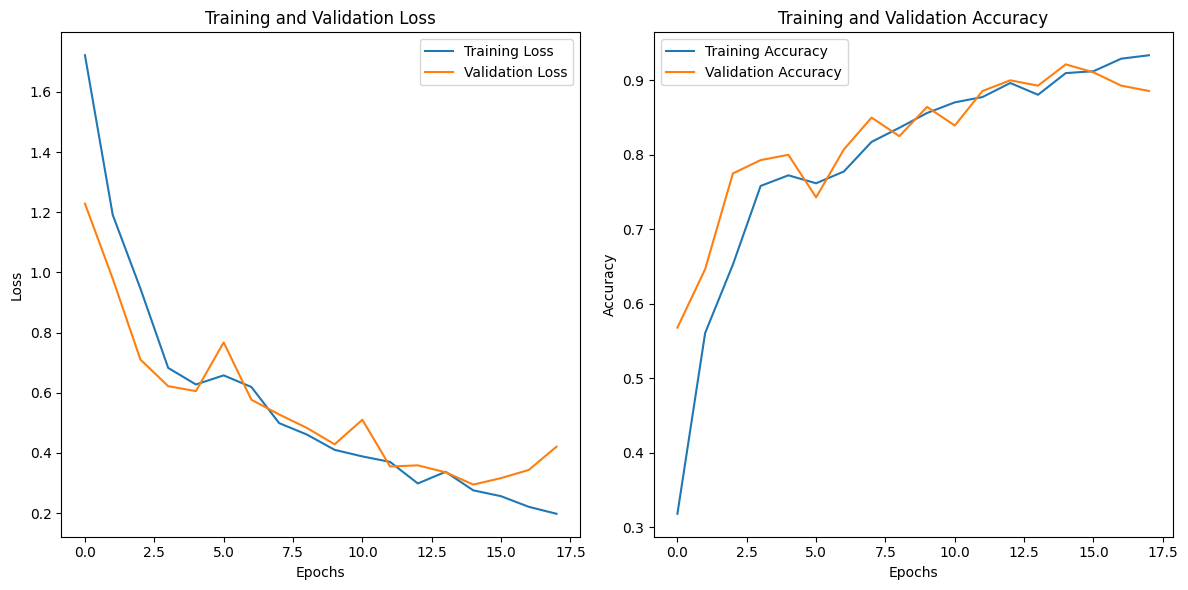

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9054 - loss: 0.3109 
Test Loss: 0.3065750300884247
Test Accuracy: 0.8946428298950195


In [ ]:
# ทำนายข้อมูลทดสอบ
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # หาคลาสที่ทำนาย
true_classes = np.argmax(y_test_encoded, axis=1)  # หาคลาสจริง

# คำนวณความแม่นยำในการทำนาย
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Accuracy: {accuracy*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 89.46%


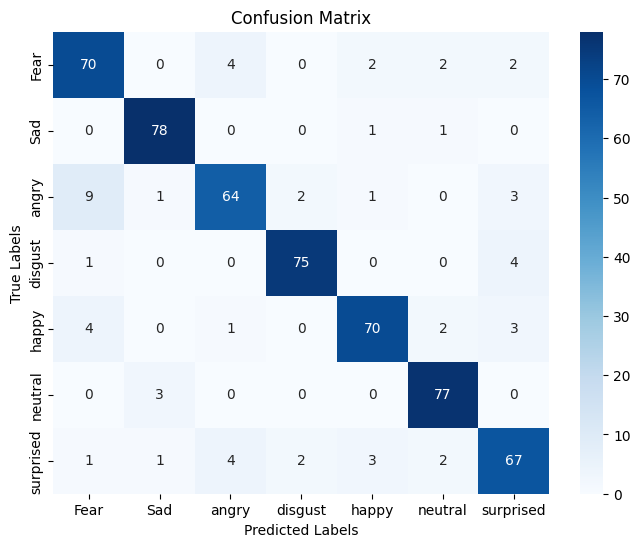

/var/folders/rm/kk7dss090cg7vpdp72ypd2b80000gp/T/ipykernel_28370/4285825394.py:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_custom_layer (MyCustomLayer) │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 970 (3.79 KB)

 Trainable params: 970 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

import tensorflow as tf

class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)

# การบันทึก
model = tf.keras.Sequential([
    MyCustomLayer(32, input_shape=(20,)),
    tf.keras.layers.Dense(10)
])
model.save("model_new.h5")

# การโหลด
model = tf.keras.models.load_model("model_new.h5", custom_objects={'MyCustomLayer': MyCustomLayer}, compile=False)
model.summary()



In [41]:
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model

class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)

model = tf.keras.models.load_model("/Users/gam/Desktop/DEEP/Woekshop#3/model_new.h5", custom_objects={'MyCustomLayer': MyCustomLayer}, compile=False)
emotion_labels = ['angry', 'disgust', 'Fear', 'happy', 'neutral','Sad' , 'surprised']  # ปรับตาม Dataset
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

def extract_features(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  # ใช้ n_mfcc = 10
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        
        # ถ้ามีมิติที่เกินคาดหวัง ให้ปรับให้เหลือแค่ 10 ฟีเจอร์
        mfccs = np.mean(mfccs, axis=1)  # ลดมิติในแต่ละฟีเจอร์
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((10,))
    
    
    

# โหลดและแปลงไฟล์เสียง
file_path = "/Users/gam/Desktop/DEEP/Woekshop#3/DATASET/Dataset_2/train/surprised/YAF_wire_ps.wav"  # เปลี่ยนเป็น path ไฟล์เสียงของคุณ
input_data = extract_features(file_path)
input_data = np.expand_dims(input_data, axis=0)  # เพิ่ม batch dimension

# พยากรณ์ผลลัพธ์
predictions = model.predict(input_data)

# ใช้ softmax เพื่อแปลง logits เป็นความน่าจะเป็น
softmax_probs = tf.nn.softmax(predictions).numpy()[0]  # แปลง logits เป็น probability

# แสดงความน่าจะเป็นของแต่ละคลาส
for label, prob in zip(label_encoder.classes_, softmax_probs):
    print(f"{label}: {prob:.4f}")

# เลือก class ที่ค่ามากสุด
predicted_label = np.argmax(softmax_probs)

# ตรวจสอบว่า predicted_label อยู่ในช่วงคลาสที่รู้จัก
if np.all(predicted_label < len(label_encoder.classes_)):
    predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]
else:
    predicted_emotion = "Unknown"  # หรือข้อความที่เหมาะสมสำหรับกรณีนี้

print("\nPredicted Label:", predicted_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fear: 0.4785
Sad: 0.0490
angry: 0.0008
disgust: 0.4713
happy: 0.0001
neutral: 0.0000
surprised: 0.0003

Predicted Label: Fear


/var/folders/rm/kk7dss090cg7vpdp72ypd2b80000gp/T/ipykernel_30784/2186312487.py:9: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
